In [ ]:
import pandas as pd
import numpy as np

In [5]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col,to_timestamp,avg,date_format

In [7]:
# spark=SparkSession.Builder().appName("local").getOrCreate()
# client_csv=spark.read.csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv",header=True,inferSchema=True)
# train_csv=spark.read.csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv",header=True,inferSchema=True)

client_csv=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv")
train_csv=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv")

In [11]:
client_csv=client_csv.rename(columns={"product_type":"client_product_type","is_business":"c_business","county":"client_county"})

In [12]:
client_csv.columns

Index(['client_product_type', 'client_county', 'eic_count',
       'installed_capacity', 'c_business', 'date', 'data_block_id'],
      dtype='object')

In [14]:
client_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_product_type  41919 non-null  int64  
 1   client_county        41919 non-null  int64  
 2   eic_count            41919 non-null  int64  
 3   installed_capacity   41919 non-null  float64
 4   c_business           41919 non-null  int64  
 5   date                 41919 non-null  object 
 6   data_block_id        41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.6+ MB


In [15]:
client_csv["date"]=pd.to_datetime(client_csv["date"])

In [16]:
client_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_product_type  41919 non-null  int64         
 1   client_county        41919 non-null  int64         
 2   eic_count            41919 non-null  int64         
 3   installed_capacity   41919 non-null  float64       
 4   c_business           41919 non-null  int64         
 5   date                 41919 non-null  datetime64[ns]
 6   data_block_id        41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 2.6 MB


In [7]:
# client_csv=client_csv.drop(*["eic_count","data_block_id"])

In [8]:
train_csv=train_csv.withColumn("datetime",to_timestamp(col("datetime"),"YYYY-MM-DD"))

In [9]:
elec_price=spark.read.csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv",header=True,inferSchema=True)
elec_price.show()

+-------------------+-------------+-------------------+-------------+
|      forecast_date|euros_per_mwh|        origin_date|data_block_id|
+-------------------+-------------+-------------------+-------------+
|2021-09-01 00:00:00|        92.51|2021-08-31 00:00:00|            1|
|2021-09-01 01:00:00|         88.9|2021-08-31 01:00:00|            1|
|2021-09-01 02:00:00|        87.35|2021-08-31 02:00:00|            1|
|2021-09-01 03:00:00|        86.88|2021-08-31 03:00:00|            1|
|2021-09-01 04:00:00|        88.43|2021-08-31 04:00:00|            1|
|2021-09-01 05:00:00|        93.58|2021-08-31 05:00:00|            1|
|2021-09-01 06:00:00|        118.7|2021-08-31 06:00:00|            1|
|2021-09-01 07:00:00|       135.44|2021-08-31 07:00:00|            1|
|2021-09-01 08:00:00|       140.72|2021-08-31 08:00:00|            1|
|2021-09-01 09:00:00|        130.0|2021-08-31 09:00:00|            1|
|2021-09-01 10:00:00|       116.99|2021-08-31 10:00:00|            1|
|2021-09-01 11:00:00

In [10]:
elec_price=elec_price.withColumn("forecast_date",to_timestamp(col("forecast_date"),"YYYY-MM-DD"))
elec_price.show()

+-------------------+-------------+-------------------+-------------+
|      forecast_date|euros_per_mwh|        origin_date|data_block_id|
+-------------------+-------------+-------------------+-------------+
|2021-09-01 00:00:00|        92.51|2021-08-31 00:00:00|            1|
|2021-09-01 01:00:00|         88.9|2021-08-31 01:00:00|            1|
|2021-09-01 02:00:00|        87.35|2021-08-31 02:00:00|            1|
|2021-09-01 03:00:00|        86.88|2021-08-31 03:00:00|            1|
|2021-09-01 04:00:00|        88.43|2021-08-31 04:00:00|            1|
|2021-09-01 05:00:00|        93.58|2021-08-31 05:00:00|            1|
|2021-09-01 06:00:00|        118.7|2021-08-31 06:00:00|            1|
|2021-09-01 07:00:00|       135.44|2021-08-31 07:00:00|            1|
|2021-09-01 08:00:00|       140.72|2021-08-31 08:00:00|            1|
|2021-09-01 09:00:00|        130.0|2021-08-31 09:00:00|            1|
|2021-09-01 10:00:00|       116.99|2021-08-31 10:00:00|            1|
|2021-09-01 11:00:00

In [11]:
elec_price=elec_price.drop(*["origin_date","data_block_id"])

In [12]:
elec_price.columns

['forecast_date', 'euros_per_mwh']

In [13]:
train=train_csv.join(elec_price,on=[elec_price.forecast_date==train_csv.datetime])

In [14]:
train.columns

['county',
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'datetime',
 'data_block_id',
 'row_id',
 'prediction_unit_id',
 'forecast_date',
 'euros_per_mwh']

In [15]:
train.count()

2014966

In [16]:
client_csv.show(2)

+-------------------+-------------+---------+------------------+----------+-------------------+-------------+
|client_product_type|client_county|eic_count|installed_capacity|c_business|               date|data_block_id|
+-------------------+-------------+---------+------------------+----------+-------------------+-------------+
|                  1|            0|      108|            952.89|         0|2021-09-01 00:00:00|            2|
|                  2|            0|       17|             166.4|         0|2021-09-01 00:00:00|            2|
+-------------------+-------------+---------+------------------+----------+-------------------+-------------+
only showing top 2 rows



In [17]:
client_csv.columns

['client_product_type',
 'client_county',
 'eic_count',
 'installed_capacity',
 'c_business',
 'date',
 'data_block_id']

In [18]:
gas_price=spark.read.csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv",header=True,inferSchema=True)


In [19]:
gas_price.show()

+-------------+--------------------+---------------------+-----------+-------------+
|forecast_date|lowest_price_per_mwh|highest_price_per_mwh|origin_date|data_block_id|
+-------------+--------------------+---------------------+-----------+-------------+
|   2021-09-01|               45.23|                46.32| 2021-08-31|            1|
|   2021-09-02|               45.62|                46.29| 2021-09-01|            2|
|   2021-09-03|               45.85|                 46.4| 2021-09-02|            3|
|   2021-09-04|                46.3|                 46.8| 2021-09-03|            4|
|   2021-09-05|                46.3|                46.58| 2021-09-04|            5|
|   2021-09-06|               46.17|                46.95| 2021-09-05|            6|
|   2021-09-07|               46.35|                 47.6| 2021-09-06|            7|
|   2021-09-08|                46.4|                47.64| 2021-09-07|            8|
|   2021-09-09|               44.96|                47.72| 2021-0

In [20]:
gas_price.printSchema()

root
 |-- forecast_date: date (nullable = true)
 |-- lowest_price_per_mwh: double (nullable = true)
 |-- highest_price_per_mwh: double (nullable = true)
 |-- origin_date: date (nullable = true)
 |-- data_block_id: integer (nullable = true)



In [21]:
client_csv.columns

['client_product_type',
 'client_county',
 'eic_count',
 'installed_capacity',
 'c_business',
 'date',
 'data_block_id']

In [22]:
client_csv=client_csv.drop("data_block_id")

In [23]:
client_csv=client_csv.join(gas_price,[client_csv.date==gas_price.forecast_date],how="inner")

In [24]:
client_csv.show(10)

+-------------------+-------------+---------+------------------+----------+-------------------+-------------+--------------------+---------------------+-----------+-------------+
|client_product_type|client_county|eic_count|installed_capacity|c_business|               date|forecast_date|lowest_price_per_mwh|highest_price_per_mwh|origin_date|data_block_id|
+-------------------+-------------+---------+------------------+----------+-------------------+-------------+--------------------+---------------------+-----------+-------------+
|                  1|            0|      108|            952.89|         0|2021-09-01 00:00:00|   2021-09-01|               45.23|                46.32| 2021-08-31|            1|
|                  2|            0|       17|             166.4|         0|2021-09-01 00:00:00|   2021-09-01|               45.23|                46.32| 2021-08-31|            1|
|                  3|            0|      688|           7207.88|         0|2021-09-01 00:00:00|   2021-09

In [25]:
client_csv=client_csv.drop(*["date","forecast_date","origin_date","eic_count"])

In [26]:
train=train.drop(*["datetime","row_id","prediction_unit_id","forecast_date"])

In [27]:
train.columns

['county',
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'data_block_id',
 'euros_per_mwh']

In [28]:
train=train.join(client_csv,on=[train_csv.data_block_id+1 == client_csv.data_block_id,train_csv.is_business==client_csv.c_business,train_csv.product_type==client_csv.client_product_type,train_csv.county==client_csv.client_county])

In [29]:
train.count()

2011846

In [30]:
train.columns

['county',
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'data_block_id',
 'euros_per_mwh',
 'client_product_type',
 'client_county',
 'installed_capacity',
 'c_business',
 'lowest_price_per_mwh',
 'highest_price_per_mwh',
 'data_block_id']

In [31]:
train=train.drop(*["client_product_type","client_county","c_business","data_block_id","row_id","prediction_unit_id","datetime"])

In [32]:
train=train.dropna()

In [33]:
train.count()

2011318

average_df = elec_price.withColumn("date", date_format(elec_price.forecast_date, "yyyy-MM-dd")).groupBy("date").agg(avg("euros_per_mwh").alias("average_euros_per_mwh"))

average_df.count()

In [34]:
train.columns

['county',
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'euros_per_mwh',
 'installed_capacity',
 'lowest_price_per_mwh',
 'highest_price_per_mwh']

In [35]:
df=train.toPandas()

In [36]:
df.head()

,county,is_business,product_type,target,is_consumption,euros_per_mwh,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh
0,0,1,1,0.000,0,96.99,1411.0,45.62,46.29
1,0,1,1,502.241,1,96.99,1411.0,45.62,46.29
2,0,1,1,0.000,0,94.77,1411.0,45.62,46.29
3,0,1,1,545.148,1,94.77,1411.0,45.62,46.29
4,0,1,1,0.000,0,93.88,1411.0,45.62,46.29


In [37]:
feature_columns=df.drop("target",axis=1).copy()
target_column=df["target"].copy()

In [38]:
from sklearn.preprocessing import StandardScaler

In [40]:
features=StandardScaler().fit_transform(feature_columns)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
x_train,x_test,y_train,y_test=train_test_split(features,target_column,test_size=0.2)

In [43]:
x_train.shape,x_test.shape

((1609054, 8), (402264, 8))

In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse'             # Root Mean Squared Error as evaluation metric
}

# Train the XGBoost model
num_rounds = 2000
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions
predictions = xgb_model.predict(dtest)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 217.40501523505856


In [123]:
len(predictions)

402264

In [121]:
y_test

1219386      0.000
613389     194.200
582775      65.202
1260154      2.296
843090       0.108
            ...   
963818       0.000
806340      24.197
577178      55.428
1231405     22.450
1924591     66.588
Name: target, Length: 402264, dtype: float64

In [124]:
pd.DataFrame({"actual":y_test,"prediction":predictions})

,actual,prediction
1219386,0.000,-13.877900
613389,194.200,440.429047
582775,65.202,98.067787
1260154,2.296,-142.324844
843090,0.108,14.489762
...,...,...
963818,0.000,81.959167
806340,24.197,-7.729585
577178,55.428,19.473427
1231405,22.450,27.833769


R-squared: 0.9417880485598279


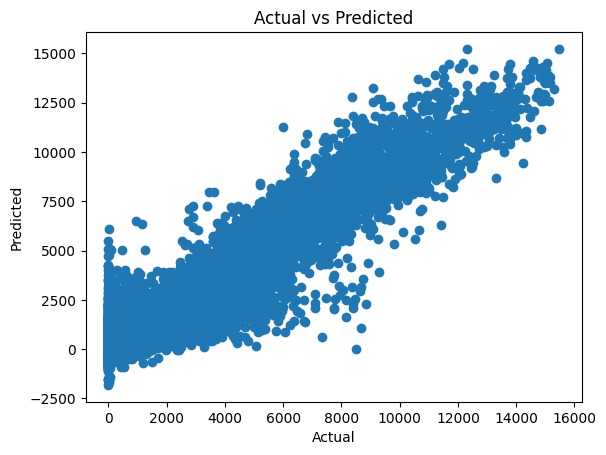

In [45]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
predictions = xgb_model.predict(dtest)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

# Plotting
plt.scatter(y_test, predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

In [ ]:
df["avg_mwh"]=(df.highest_price_per_mwh+df.lowest_price_per_mwh)/2

In [79]:
df.corr()

,county,is_business,product_type,target,is_consumption,euros_per_mwh,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh
county,1.000000e+00,2.633023e-02,1.029586e-02,-0.098724,-4.714883e-20,5.553407e-04,-1.675068e-01,6.697553e-05,1.880612e-04
is_business,2.633023e-02,1.000000e+00,-8.806876e-02,0.163110,2.413202e-20,2.721072e-03,7.020904e-02,7.021848e-03,7.680678e-03
product_type,1.029586e-02,-8.806876e-02,1.000000e+00,0.174820,1.653362e-20,-3.628888e-03,3.317062e-01,-9.744586e-03,-1.065118e-02
target,-9.872358e-02,1.631095e-01,1.748198e-01,1.000000,2.051006e-01,1.131867e-02,6.083502e-01,-1.408813e-02,-1.257445e-02
is_consumption,-4.714883e-20,2.413202e-20,1.653362e-20,0.205101,1.000000e+00,-1.335313e-19,1.036098e-20,-1.447405e-19,6.455319e-21
euros_per_mwh,5.553407e-04,2.721072e-03,-3.628888e-03,0.011319,-1.335313e-19,1.000000e+00,-9.346275e-03,5.510264e-01,5.553810e-01
installed_capacity,-1.675068e-01,7.020904e-02,3.317062e-01,0.608350,1.036098e-20,-9.346275e-03,1.000000e+00,-2.016036e-02,-1.658329e-02
lowest_price_per_mwh,6.697553e-05,7.021848e-03,-9.744586e-03,-0.014088,-1.447405e-19,5.510264e-01,-2.016036e-02,1.000000e+00,9.810919e-01
highest_price_per_mwh,1.880612e-04,7.680678e-03,-1.065118e-02,-0.012574,6.455319e-21,5.553810e-01,-1.658329e-02,9.810919e-01,1.000000e+00


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

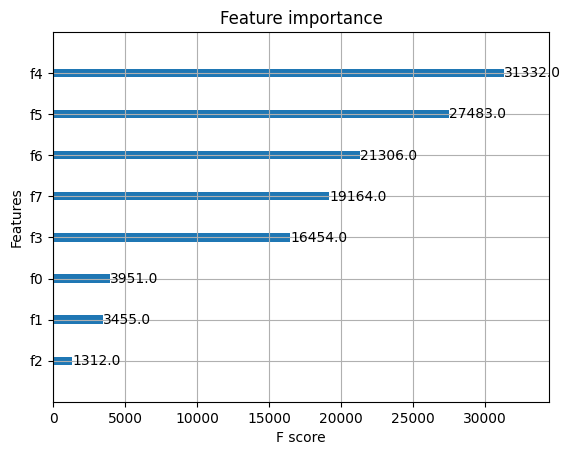

In [80]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [82]:
client_test=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv")
elec_test=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv")
gas_test=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv")


In [83]:
test=pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv")

In [84]:
client_test

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,507,4960.215,0,2023-05-26,634
1,2,0,11,34.000,0,2023-05-26,634
2,3,0,1516,15977.560,0,2023-05-26,634
3,0,0,25,1273.200,1,2023-05-26,634
4,1,0,98,2885.600,1,2023-05-26,634
...,...,...,...,...,...,...,...
257,1,15,51,415.600,0,2023-05-29,637
258,3,15,161,2035.750,0,2023-05-29,637
259,0,15,15,620.000,1,2023-05-29,637
260,1,15,20,624.500,1,2023-05-29,637


In [91]:
elec_test.rename(columns={"forecast_date":"prediction_datetime"},inplace=True)

In [92]:
elec_test

,prediction_datetime,euros_per_mwh,origin_date,data_block_id
0,2023-05-27 00:00:00,87.54,2023-05-26 00:00:00,634
1,2023-05-27 01:00:00,82.69,2023-05-26 01:00:00,634
2,2023-05-27 02:00:00,82.70,2023-05-26 02:00:00,634
3,2023-05-27 03:00:00,84.26,2023-05-26 03:00:00,634
4,2023-05-27 04:00:00,87.67,2023-05-26 04:00:00,634
...,...,...,...,...
91,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
92,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
93,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
94,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


In [90]:
test

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False
...,...,...,...,...,...,...,...,...,...
12475,15,1,0,1,2023-05-31 23:00:00,637,2018347,64,False
12476,15,1,1,0,2023-05-31 23:00:00,637,2018348,59,False
12477,15,1,1,1,2023-05-31 23:00:00,637,2018349,59,False
12478,15,1,3,0,2023-05-31 23:00:00,637,2018350,60,False


In [94]:
test_df=test.merge(elec_test,on="prediction_datetime")

In [95]:
client_test

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,507,4960.215,0,2023-05-26,634
1,2,0,11,34.000,0,2023-05-26,634
2,3,0,1516,15977.560,0,2023-05-26,634
3,0,0,25,1273.200,1,2023-05-26,634
4,1,0,98,2885.600,1,2023-05-26,634
...,...,...,...,...,...,...,...
257,1,15,51,415.600,0,2023-05-29,637
258,3,15,161,2035.750,0,2023-05-29,637
259,0,15,15,620.000,1,2023-05-29,637
260,1,15,20,624.500,1,2023-05-29,637


In [97]:
gas_test.rename(columns={"origin_date":"date"},inplace=True)

In [99]:
merge=client_test.merge(gas_test,on=["data_block_id","date"])

In [100]:
test_df

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id_x,row_id,prediction_unit_id,currently_scored,euros_per_mwh,origin_date,data_block_id_y
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,85.00,2023-05-27 00:00:00,635
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,85.00,2023-05-27 00:00:00,635
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,85.00,2023-05-27 00:00:00,635
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,85.00,2023-05-27 00:00:00,635
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,85.00,2023-05-27 00:00:00,635
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,15,1,0,1,2023-05-30 23:00:00,636,2015227,64,False,-1.29,2023-05-29 23:00:00,637
9356,15,1,1,0,2023-05-30 23:00:00,636,2015228,59,False,-1.29,2023-05-29 23:00:00,637
9357,15,1,1,1,2023-05-30 23:00:00,636,2015229,59,False,-1.29,2023-05-29 23:00:00,637
9358,15,1,3,0,2023-05-30 23:00:00,636,2015230,60,False,-1.29,2023-05-29 23:00:00,637


In [103]:
merge.rename(columns={"data_block_id":"data_block_id_x"},inplace=True)

In [106]:
test_df=test_df.merge(merge,on="data_block_id_x")

In [108]:
test_df.drop(["prediction_datetime","data_block_id_x","row_id","prediction_unit_id","currently_scored","data_block_id_y",'product_type_y',"eic_count","is_business_y","forecast_date"],axis=1,inplace=True)

In [110]:
test_df.drop(["origin_date","county_y","date"],axis=1,inplace=True)

In [111]:
test_feature=StandardScaler().fit_transform(test_df)

In [114]:
test_feature=xgb.DMatrix(test_feature)


/opt/conda/lib/python3.10/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.DMatrix'>

In [115]:
out=xgb_model.predict(test_feature)

In [116]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [118]:
counter = 0
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(client.head(3))
        print(historical_weather.head(3))
        print(forecast_weather.head(3))
        print(electricity_prices.head(3))
        print(gas_prices.head(3))
        print(sample_prediction.head(3))
    sample_prediction['target'] = out
    env.predict(sample_prediction)
    counter += 1

In [125]:
import numpy as np
import statsmodels.api as sm



# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(target_column, features).fit()

# Get F-statistic and associated p-value
f_statistic = model.fvalue
p_value = model.f_pvalue

print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 161913.9660747263
p-value: 0.0
